In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-t784kx__
  Stored in directory: /tmp/pip-ephem-wheel-cache-8veeoek6/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import glob
import imageio
from skimage.transform import resize

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [0]:
%%bash
FILE="cityscapes"

if [[ $FILE != "ae_photos" && $FILE != "apple2orange" && $FILE != "summer2winter_yosemite" &&  $FILE != "horse2zebra" && $FILE != "monet2photo" && $FILE != "cezanne2photo" && $FILE != "ukiyoe2photo" && $FILE != "vangogh2photo" && $FILE != "maps" && $FILE != "cityscapes" && $FILE != "facades" && $FILE != "iphone2dslr_flower" && $FILE != "ae_photos" ]]; then
    echo "Available datasets are: apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos"
    exit 1
fi

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE
mkdir -p ./datasets
mkdir -p ./saved
wget -N -q $URL -O $ZIP_FILE
unzip -q $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

#Data loading

Class to build training and validation batch

In [0]:
class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob.glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            img = resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob.glob('datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob.glob('datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = resize(img_A, self.img_res)
                img_B = resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return imageio.imread(path, pilmode='RGB').astype(np.float)

# Cycle consistent GAN

In [0]:
def conv_block(layer_input, filters, f_size=4, normalization=True):
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    if normalization:
        d = InstanceNormalization()(d)
    return d

def deconv_block(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
    if dropout_rate:
        u = Dropout(dropout_rate)(u)
    u = InstanceNormalization()(u)
    u = Concatenate()([u, skip_input])
    return u
        
def build_generator(img_shape,num_filter,num_channels):
    d0 = Input(shape=img_shape)
        
    # Downsampling
    d1 = conv_block(d0, num_filter)
    d2 = conv_block(d1, num_filter * 2)
    d3 = conv_block(d2, num_filter * 4)
    d4 = conv_block(d3, num_filter * 8)
        
    # Upsampling
    u1 = deconv_block(d4, d3, num_filter * 4)
    u2 = deconv_block(u1, d2, num_filter * 2)
    u3 = deconv_block(u2, d1, num_filter)
        
    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(num_channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)
        
    return Model(d0, output_img)
        
def build_discriminator(img_shape,num_filter):
    img = Input(shape=img_shape)
        
    d1 = conv_block(img, num_filter, normalization=False)
    d2 = conv_block(d1, num_filter * 2)
    d3 = conv_block(d2, num_filter * 4)
    d4 = conv_block(d3, num_filter * 8)
        
    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
        
    return Model(img, validity)

In [0]:
class CycleGAN():
    def __init__(self, img_rows=128, img_cols=128, channels=3, dataset_name='maps'):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (img_rows, img_cols, channels)
        
        self.dataset_name = dataset_name
        self.data_loader = DataLoader(self.dataset_name, img_res=(self.img_rows, self.img_cols))
        
        if not os.path.isdir('images'):
            os.mkdir('images', 0o755)
        if not os.path.isdir(os.path.join('images', self.dataset_name)):
            os.mkdir(os.path.join('images', self.dataset_name), 0o755)
        
        # Calculate output shape of D 
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)
        
        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64
        
        # control enforcement of cycle-consistency loss
        self.lambda_cycle = 10.0
        self.lambda_id = 0.9 * self.lambda_cycle
        
        optimizer = Adam(0.0002, 0.5)
        
        # discriminators
        self.d_a = build_discriminator(self.img_shape,self.df)
        self.d_b = build_discriminator(self.img_shape,self.df)

        self.d_a.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        self.d_b.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

        # generators
        self.g_ab = build_generator(self.img_shape,self.gf,self.channels)
        self.g_ba = build_generator(self.img_shape,self.gf,self.channels)
        
        # Input the images
        img_a = Input(shape=self.img_shape)
        img_b = Input(shape=self.img_shape)
       
        translated_b = self.g_ab(img_a)
        translated_a = self.g_ba(img_b)
        
        # Translate images back to original domain
        recon_a = self.g_ba(translated_b)
        recon_b = self.g_ab(translated_a)
        
        #identity mappig
        img_a_id = self.g_ba(img_a)
        img_b_id = self.g_ab(img_b)
        
        # train only the generators together
        self.d_a.trainable = False
        self.d_b.trainable = False
        
        valid_a = self.d_a(translated_a)
        valid_b = self.d_b(translated_b)
        
        self.combined = Model(inputs=[img_a, img_b], output=[valid_a, valid_b, recon_a, recon_b, img_a_id, img_b_id])
        self.combined.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                             loss_weights=[1, 1, self.lambda_cycle, self.lambda_cycle, self.lambda_id, self.lambda_id], optimizer=optimizer)
        
    
    def sample_images(self, epoch, batch_i):
        r, c = 2, 4

        imgs_a = self.data_loader.load_data(domain="A", batch_size=2, is_testing=True)
        imgs_b = self.data_loader.load_data(domain="B", batch_size=2, is_testing=True)
       
        translated_b = self.g_ab.predict(imgs_a)
        translated_a = self.g_ba.predict(imgs_b)
        
        #reconstr_a = self.g_ba.predict(fake_b)
        #reconstr_b = self.g_ab.predict(fake_a)

        #gen_imgs = np.concatenate([imgs_a, fake_b, reconstr_a, imgs_b, fake_a, reconstr_b])
        gen_imgs = np.concatenate([imgs_a, imgs_b, translated_b, translated_a])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        #titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c, figsize=(12,6))
        fig.subplots_adjust(hspace=0, wspace=0)
        cnt = 0
        for i in range(r):
            #axs[i,0].set_title(titles[i])
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()
    
    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()
        
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        for epoch in range(epochs):
            for batch_i, (imgs_a, imgs_b) in enumerate(self.data_loader.load_batch(batch_size)):
                
                # Translate images to opposite domain
                fake_b = self.g_ab.predict(imgs_a)
                fake_a = self.g_ba.predict(imgs_b)
                
                # Train the discriminators (original images = real / translated = Fake)
                da_loss_real = self.d_a.train_on_batch(imgs_a, valid)
                da_loss_fake = self.d_a.train_on_batch(fake_a, fake)
                da_loss = 0.5 * np.add(da_loss_real, da_loss_fake)

                db_loss_real = self.d_b.train_on_batch(imgs_b, valid)
                db_loss_fake = self.d_b.train_on_batch(fake_b, fake)
                db_loss = 0.5 * np.add(db_loss_real, db_loss_fake)

                d_loss = 0.5 * np.add(da_loss, db_loss)
                
                g_loss = self.combined.train_on_batch([imgs_a, imgs_b], [valid, valid, imgs_a, imgs_b, imgs_a, imgs_b])

            if epoch % sample_interval == 0:
                print('epoch: {} generator loss: {} discriminator loss: {}'.format(epoch, g_loss, d_loss))
                self.sample_images(epoch, batch_i)
            if epoch % 33 == 0:
                save_name = 'saved/' + '{}' + str(epoch) + '.h5'
                self.g_ab.save_weights(save_name.format('GAB_weights_'))
                self.g_ba.save_weights(save_name.format('GBA_weights_'))

In [0]:
gan = CycleGAN(img_cols =256, img_rows = 256, dataset_name='cityscapes')

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [0]:
gan = CycleGAN(dataset_name='cityscapes')

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0 generator loss: [10.829102, 0.82109106, 1.4023979, 0.22434238, 0.29496127, 0.14765874, 0.23151644] discriminator loss: [0.46713197 0.3458252 ]


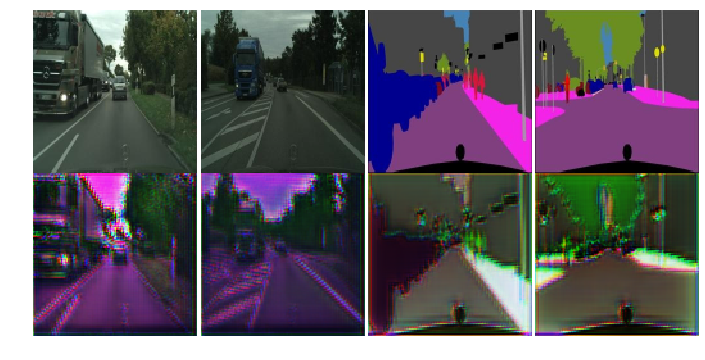

In [0]:
gan.train(epochs=1, batch_size=64, sample_interval=1)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


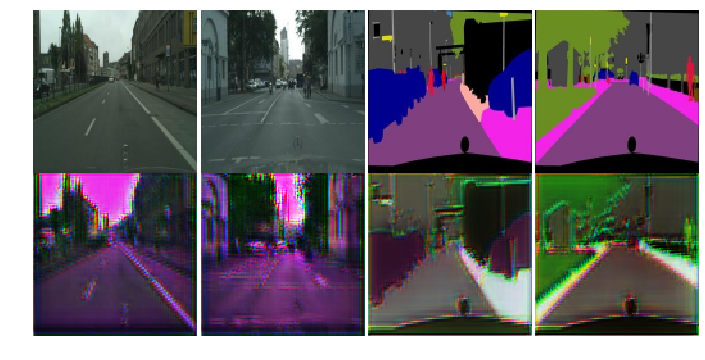

In [0]:
gan.sample_images(100, 0)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


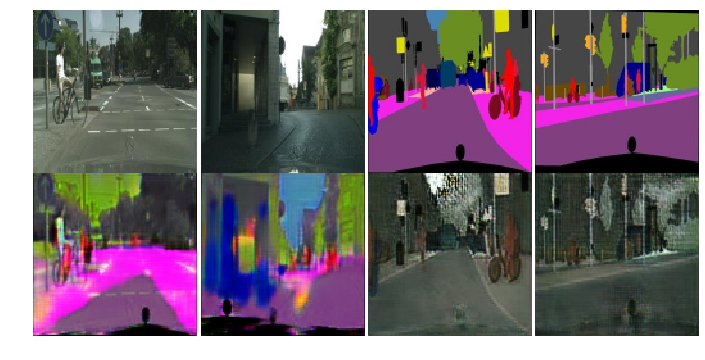

In [0]:
gan.sample_images(100, 0)

In [0]:
gan.g_ab.save_weights('GAB_weights_100.h5')
gan.g_ba.save_weights('GBA_weights_100.h5')
gan.d_a.save_weights('DA_weights_100.h5')
gan.d_b.save_weights('DB_weights_100.h5')

In [0]:
gan.g_ba.load_weights('GBA_weights_100.h5')
gan.g_ab.load_weights('GAB_weights_100.h5')

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


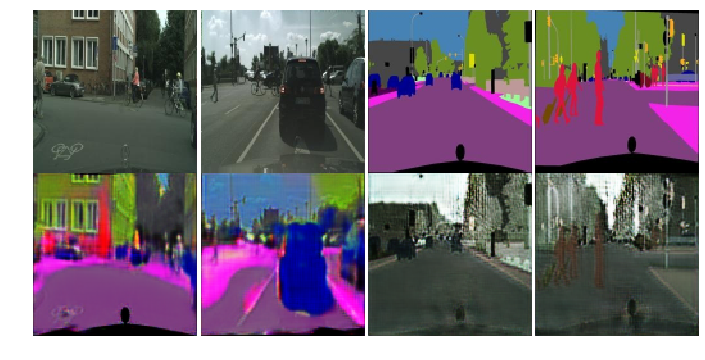

In [0]:
gan.sample_images(99, 0)

In [0]:
!mkdir fcn_in
!mkdir fcn_out

In [0]:
def load_test_data(domain="A", batch_size=1, is_testing=True):
    data_type = "train%s" % domain if not is_testing else "test%s" % domain
    path = glob.glob('./datasets/%s/%s/*' % ('cityscapes', data_type))
    img_size= (128, 128)
        
    i = 0
    for img_path in path:
        plt.axis('off')
        img = gan.data_loader.imread(img_path)
        img = resize(img, img_size)
        imgs = [img]
        imgs = np.array(imgs)/127.5 - 1.
        plt.clf()
        plt.imshow(imgs.reshape(128,128,3))
        plt.savefig('fcn_in/'+ str(i))
        translated_b = gan.g_ab.predict(imgs)
        translated_b = 0.5 * translated_b + 0.5
        out = translated_b.reshape(128,128, 3)
        plt.clf()
        plt.imshow(out)
        plt.savefig('fcn_out/'+ str(i))
        i+=1
#     imgs.append(img)
#     imgs = np.array(imgs)/127.5 - 1.

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB d

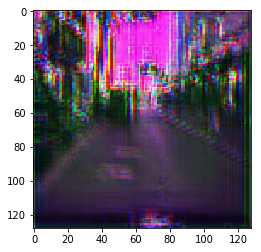

In [0]:
load_test_data()

In [0]:
%%bash
URL=http://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/fcn-8s-cityscapes/fcn-8s-cityscapes.caffemodel
mkdir caffemodel
OUTPUT_FILE=caffemodel/fcn-8s-cityscapes.caffemodel
wget -N -q $URL -O $OUTPUT_FILE

In [0]:
!apt install -y caffe-cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  caffe-tools-cuda cython3 fonts-lyx javascript-common libblosc1
  libcaffe-cuda1 libcublas9.1 libcudart9.1 libcurand9.1 libgflags2.2
  libgoogle-glog0v5 libjs-jquery libjs-jquery-ui libleveldb1v5 liblmdb0
  python-matplotlib-data python-tables-data python3-bs4 python3-caffe-cuda
  python3-chardet python3-cycler python3-dateutil python3-decorator
  python3-gflags python3-h5py python3-html5lib python3-ipython
  python3-ipython-genutils python3-leveldb python3-matplotlib python3-networkx
  python3-nose python3-numexpr python3-pandas python3-pandas-lib
  python3-pexpect python3-pickleshare python3-pkg-resources
  python3-prompt-toolkit python3-protobuf python3-ptyprocess python3-pygments
  python3-pyparsing py

In [0]:
!mv ./caffemodel/fcn-8s-cityscapes.caffemodel ./caffemodelfcn-8s-cityscapes.caffemodel

In [0]:
!cp ./caffemodel/caffemodelfcn-8s-cityscapes.caffemodel ./caffemodelfcn-8s-cityscapes.caffemodel

In [0]:
!wget https://raw.githubusercontent.com/phillipi/pix2pix/4b4621dbeb7f22a0335e1f2fc598a8782b6b7240/scripts/eval_cityscapes/cityscapes.py
!wget https://raw.githubusercontent.com/phillipi/pix2pix/4b4621dbeb7f22a0335e1f2fc598a8782b6b7240/scripts/eval_cityscapes/evaluate.py
!wget https://raw.githubusercontent.com/phillipi/pix2pix/4b4621dbeb7f22a0335e1f2fc598a8782b6b7240/scripts/eval_cityscapes/util.py
!wget -O caffemodel/deploy.prototxt https://raw.githubusercontent.com/phillipi/pix2pix/4b4621dbeb7f22a0335e1f2fc598a8782b6b7240/scripts/eval_cityscapes/caffemodel/deploy.prototxt

--2019-04-20 17:55:52--  https://raw.githubusercontent.com/phillipi/pix2pix/4b4621dbeb7f22a0335e1f2fc598a8782b6b7240/scripts/eval_cityscapes/cityscapes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5773 (5.6K) [text/plain]
Saving to: ‘cityscapes.py’

cityscapes.py       100%[===================>]   5.64K  --.-KB/s    in 0s      

2019-04-20 17:55:53 (80.6 MB/s) - ‘cityscapes.py’ saved [5773/5773]

--2019-04-20 17:55:55--  https://raw.githubusercontent.com/phillipi/pix2pix/4b4621dbeb7f22a0335e1f2fc598a8782b6b7240/scripts/eval_cityscapes/evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... conne

In [0]:
!wget https://raw.githubusercontent.com/n-zhang/fcn_score/master/labels.py

--2019-04-20 17:57:29--  https://raw.githubusercontent.com/n-zhang/fcn_score/master/labels.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10597 (10K) [text/plain]
Saving to: ‘labels.py’

labels.py           100%[===================>]  10.35K  --.-KB/s    in 0s      

2019-04-20 17:57:29 (136 MB/s) - ‘labels.py’ saved [10597/10597]



In [0]:
!python evaluate.py --cityscapes_dir datasets/cityscapes/evaluate_cityscape --result_dir datasets/cityscapes/evaluate_cityscape --output_dir results --caffemodel_dir caffemodel --gpu_id 0

W0420 18:04:02.126616  1612 _caffe.cpp:139] DEPRECATION WARNING - deprecated use of Python interface
W0420 18:04:02.126725  1612 _caffe.cpp:140] Use this instead (with the named "weights" parameter):
W0420 18:04:02.126729  1612 _caffe.cpp:142] Net('caffemodel/deploy.prototxt', 1, weights='caffemodelfcn-8s-cityscapes.caffemodel')
I0420 18:04:02.128456  1612 net.cpp:51] Initializing net from parameters: 
state {
  phase: TEST
  level: 0
}
layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param {
    shape {
      dim: 1
      dim: 3
      dim: 500
      dim: 500
    }
  }
}
layer {
  name: "conv1_1"
  type: "Convolution"
  bottom: "data"
  top: "conv1_1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 64
    pad: 100
    kernel_size: 3
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name